## Assignment 2: Recommendation System

### Matthew Axell A1900421

In [78]:
# !pip install mlxtend
# !pip install implicit
!pip install --upgrade pip "setuptools<58.0"
!pip install ml_metrics --upgrade

  Obtaining dependency information for pip from https://files.pythonhosted.org/packages/8a/6a/19e9fe04fca059ccf770861c7d5721ab4c2aebc539889e97c7977528a53b/pip-24.0-py3-none-any.whl.metadata
  Using cached pip-24.0-py3-none-any.whl.metadata (3.6 kB)
  Obtaining dependency information for setuptools<58.0 from https://files.pythonhosted.org/packages/4b/b9/71687c5d2034c863db1db2e0704f5e27581ff3cb44d7f293968c5e08ceb3/setuptools-57.5.0-py3-none-any.whl.metadata
  Using cached setuptools-57.5.0-py3-none-any.whl.metadata (4.9 kB)
Using cached pip-24.0-py3-none-any.whl (2.1 MB)
Using cached setuptools-57.5.0-py3-none-any.whl (819 kB)


ERROR: To modify pip, please run the following command:
c:\Users\axell\anaconda3\python.exe -m pip install --upgrade pip setuptools<58.0


  Using cached ml_metrics-0.1.4.tar.gz (5.0 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [1 lines of output]
      error in ml_metrics setup command: use_2to3 is invalid.
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [89]:
# General imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# EDA
from itertools import combinations
from collections import Counter
import textwrap
from mlxtend.frequent_patterns import apriori, association_rules

# Preprocessing
import scipy.sparse as sparse

# Model
import implicit

# Metrics
from implicit.evaluation import AUC_at_k, precision_at_k, mean_average_precision_at_k, ndcg_at_k
from sklearn.metrics import roc_auc_score, average_precision_score, ndcg_score

### 1. Read the dataset

In [10]:
# for training and EDA
df_train = pd.read_csv('basket_data_by_date_train.csv')
display(df_train.head())
display(df_train.shape)

# for testing and displaying final results|
df_test = pd.read_csv('basket_data_by_date_test.csv')
display(df_test.head())
df_test.dropna(inplace=True)
display(df_test.shape)

print("Train Data Null Values count")
display(df_train.isnull().sum())
df_train.dropna(inplace=True)
print("After DropNA",df_train.shape)

,BillNo,Itemname,Quantity,Date,Price,CustomerID,cost
0,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,1/12/2010 8:26,3.39,17850,20.34
1,536365,GLASS STAR FROSTED T-LIGHT HOLDER,6,1/12/2010 8:26,4.25,17850,25.50
2,536365,WHITE HANGING HEART T-LIGHT HOLDER,6,1/12/2010 8:26,2.55,17850,15.30
3,536365,RED WOOLLY HOTTIE WHITE HEART.,6,1/12/2010 8:26,3.39,17850,20.34
4,536365,SET 7 BABUSHKA NESTING BOXES,2,1/12/2010 8:26,7.65,17850,15.30


(40000, 7)

,BillNo,Itemname,Quantity,Date,Price,CustomerID,cost
0,544398.0,JUMBO SHOPPER VINTAGE RED PAISLEY,1.0,18/02/2011 12:27,1.95,15311.0,1.95
1,544398.0,ZINC WILLIE WINKIE CANDLE STICK,4.0,18/02/2011 12:27,0.85,15311.0,3.40
2,544398.0,LOVE BUILDING BLOCK WORD,2.0,18/02/2011 12:27,5.95,15311.0,11.90
3,544398.0,HANGING FAIRY CAKE DECORATION,3.0,18/02/2011 12:27,2.10,15311.0,6.30
4,544398.0,RED HEART SHAPE LOVE BUCKET,1.0,18/02/2011 12:27,2.95,15311.0,2.95


(10000, 7)

Train Data Null Values count


BillNo        0
Itemname      0
Quantity      0
Date          0
Price         0
CustomerID    0
cost          0
dtype: int64

After DropNA (40000, 7)


### 2. Analyse and visualise the data

In [ ]:
display(df_train.info())
display(df_train.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   BillNo      40000 non-null  int64  
 1   Itemname    40000 non-null  object 
 2   Quantity    40000 non-null  int64  
 3   Date        40000 non-null  object 
 4   Price       40000 non-null  float64
 5   CustomerID  40000 non-null  int64  
 6   cost        40000 non-null  float64
dtypes: float64(2), int64(3), object(2)
memory usage: 2.1+ MB


None

,BillNo,Quantity,Price,CustomerID,cost
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,540254.879225,3.487700,3.732165,15577.606525,11.097411
std,2380.444952,2.611766,5.711630,1730.347123,13.298301
min,536365.000000,1.000000,0.100000,12347.000000,0.140000
25%,538093.000000,1.000000,1.650000,14224.000000,3.300000
50%,540373.000000,2.000000,2.950000,15570.000000,7.950000
75%,542360.000000,6.000000,4.650000,17220.000000,15.800000
max,544398.000000,10.000000,295.000000,18283.000000,527.700000


In [5]:
print("Unique Customers in training:\t",df_train['CustomerID'].nunique())
print("Unique Items in training:\t",df_train['Itemname'].nunique())
print("Unique Customers in testing:\t",df_test['CustomerID'].nunique())
print("Unique Items in testing:\t",df_test['Itemname'].nunique())

Unique Customers in training:	 1391
Unique Items in training:	 2523
Unique Customers in testing:	 519
Unique Items in testing:	 1752


In [132]:
# find missing itemNames in test data
missing_itemNames = set(df_test['Itemname']) - set(df_train['Itemname'])
print(missing_itemNames)
print(len(missing_itemNames))

{"MOTHER'S KITCHEN SPOON REST", 'CLASSICAL ROSE CANDLESTAND', 'BABY MOUSE RED GINGHAM DRESS', 'SMALL BLUE PROVENCAL CERAMIC BALL', 'PURPLE FOXGLOVE ARTIIFCIAL FLOWER', 'SILVER LARIAT 40CM', 'BEADED CRYSTAL HEART BLUE  LARGE', "NEW BAROQUE B'FLY NECKLACE CRYSTAL", 'WOVEN BERRIES CUSHION COVER', 'PINK AND BLACK STRING CURTAIN', 'DOLLCRAFT GIRL AMELIE', 'BULL DOG BOTTLE OPENER', 'PURPLE/TURQ FLOWERS HANDBAG', "MUM'S KITCHEN CLOCK", '4 SKY BLUE DINNER CANDLES', 'LETTER "P" BLING KEY RING', 'PURPLE/COPPER HANGING LAMPSHADE', "CLOCK MAGNET MUM'S KITCHEN", 'FLOWERS TILE COASTER', 'NUMBER TILE VINTAGE FONT 0', 'CLEAR STATIONERY BOX SET', 'SET/6 FRUIT SALAD PAPER CUPS', 'RECYCLED ACAPULCO MAT LAVENDER', 'ABC TREASURE BOOK BOX', 'RASPBERRY ANT COPPER FLOWER NECKLAC', 'FELTCRAFT GIRL NICOLE KIT', 'CHILDRENS CUTLERY RETROSPOT RED', 'GIRAFFE WOODEN RULER', 'HAIRCLIPS FORTIES FABRIC ASSORTED', 'WHITE ALLIUM  ARTIFICIAL FLOWER', 'CHILDRENS CUTLERY POLKADOT GREEN', 'ASSORTED COLOUR METAL CAT', 'PANTRY

In [280]:
# find missing itemNames in test data
missing_customers = set(df_test['CustomerID']) - set(df_train['CustomerID'])
print(missing_customers)
print(len(missing_customers))

{14336.0, 15874.0, 16389.0, 17416.0, 16394.0, 12811.0, 16913.0, 17426.0, 16915.0, 16917.0, 13851.0, 13340.0, 16414.0, 14367.0, 14880.0, 13344.0, 12834.0, 13345.0, 17442.0, 15393.0, 15397.0, 13865.0, 16426.0, 16940.0, 12845.0, 13870.0, 14895.0, 13362.0, 17462.0, 14903.0, 15416.0, 16441.0, 15932.0, 13373.0, 13884.0, 16449.0, 12866.0, 14915.0, 13382.0, 14407.0, 15944.0, 12361.0, 12873.0, 17994.0, 17995.0, 16462.0, 15951.0, 16466.0, 16980.0, 13908.0, 17499.0, 16992.0, 13410.0, 17508.0, 15974.0, 17002.0, 13931.0, 17516.0, 13421.0, 14447.0, 16495.0, 15990.0, 17535.0, 13951.0, 16517.0, 14470.0, 16518.0, 12933.0, 14473.0, 17034.0, 18056.0, 13453.0, 16014.0, 14481.0, 12945.0, 14483.0, 14995.0, 13971.0, 18068.0, 13973.0, 13975.0, 17049.0, 16546.0, 14499.0, 13476.0, 13477.0, 17063.0, 14504.0, 12458.0, 14507.0, 16045.0, 18094.0, 14513.0, 15026.0, 12980.0, 13493.0, 16566.0, 15031.0, 15543.0, 14004.0, 16057.0, 16571.0, 12988.0, 16573.0, 13501.0, 14012.0, 14013.0, 15554.0, 18114.0, 17092.0, 13509.0, 

In [7]:
df_grouped_customerItem = df_train[['CustomerID', 'Itemname', 'Quantity']].groupby(['CustomerID', 'Itemname']).sum().reset_index().sort_values(by='Quantity')
display(df_grouped_customerItem.describe())
display(df_grouped_customerItem.shape)

,CustomerID,Quantity
count,34295.000000,34295.000000
mean,15556.777927,4.067882
std,1731.302737,3.818199
min,12347.000000,1.000000
25%,14161.000000,2.000000
50%,15570.000000,3.000000
75%,17211.000000,6.000000
max,18283.000000,104.000000


(34295, 3)

In [10]:
df = df_train.copy()
df['Frequency'] = 1
df_grouped_customerItem = df[['CustomerID', 'Itemname', 'Frequency']].groupby(['CustomerID', 'Itemname']).sum().reset_index().sort_values(by='Frequency')
display(df_grouped_customerItem.describe())
display(df_grouped_customerItem.shape)

,CustomerID,Frequency
count,34295.000000,34295.000000
mean,15556.777927,1.166351
std,1731.302737,0.589511
min,12347.000000,1.000000
25%,14161.000000,1.000000
50%,15570.000000,1.000000
75%,17211.000000,1.000000
max,18283.000000,17.000000


(34295, 3)

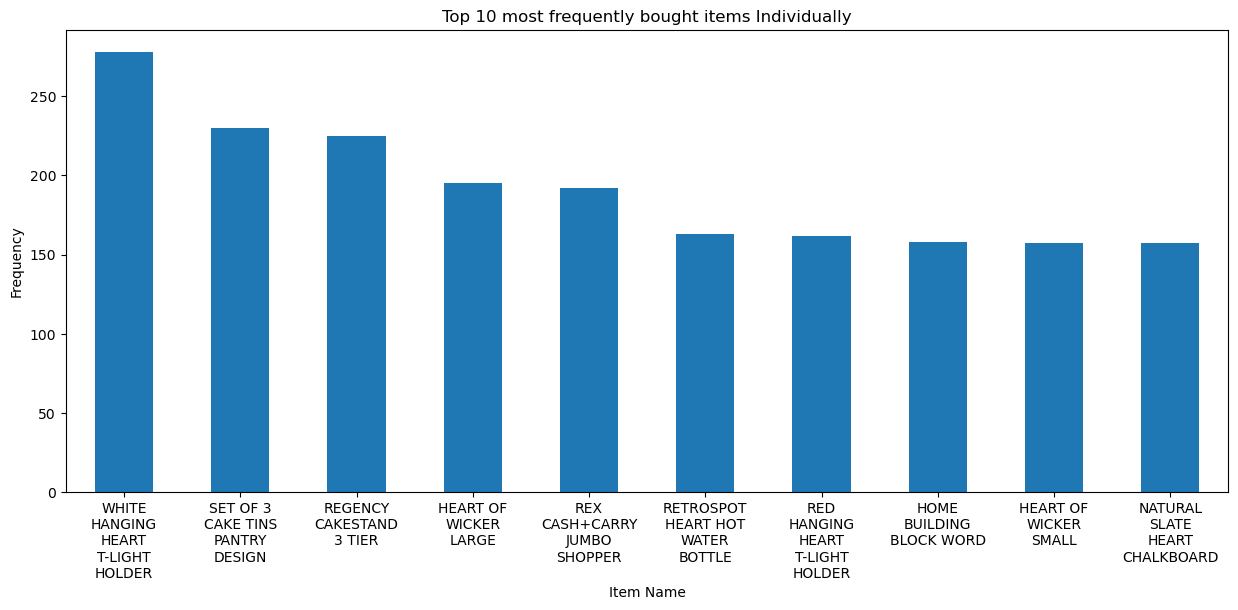

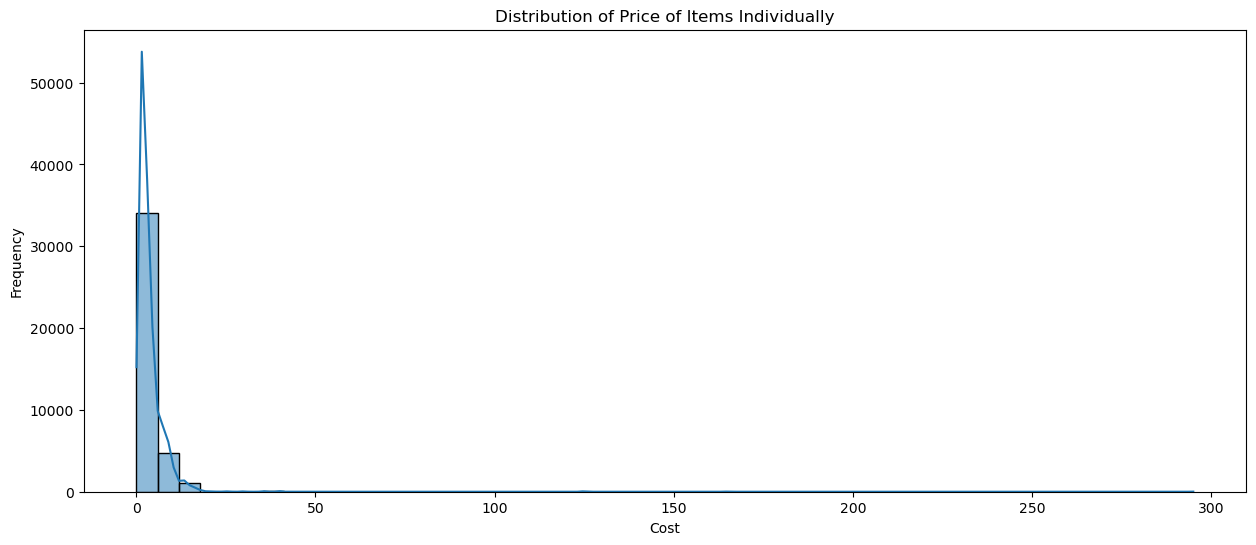

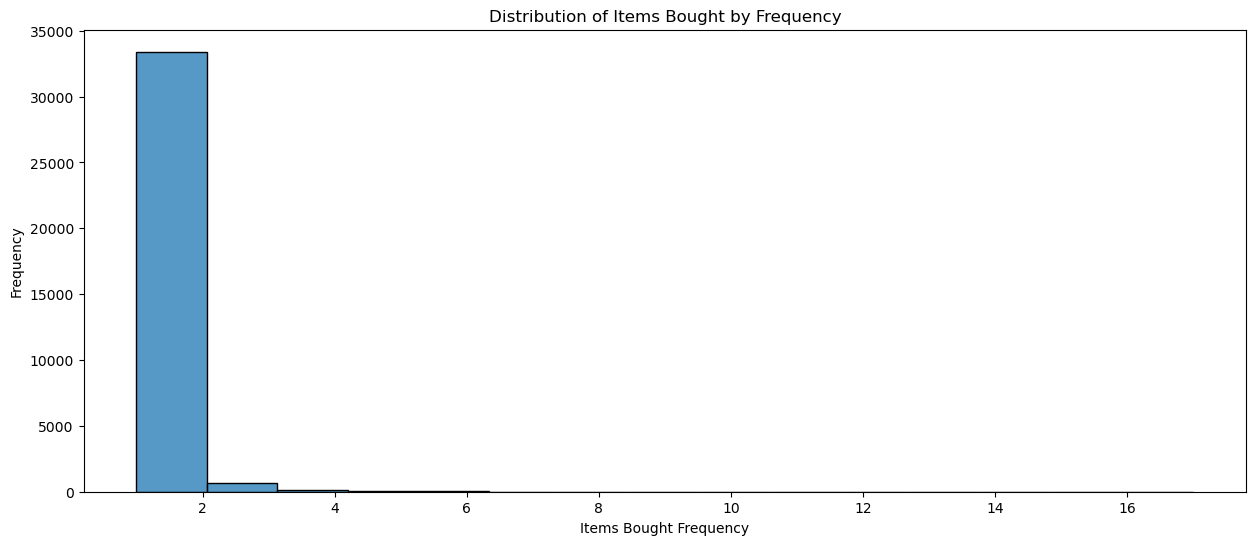

In [20]:
# Top 10 most frequently bought items
plt.figure(figsize=(15,6))
df_train['Itemname'].value_counts()[:10].plot(kind='bar')
plt.title('Top 10 most frequently bought items Individually')
plt.xlabel('Item Name')
labels = [ '\n'.join(textwrap.wrap(l, 10)) for l in df_train['Itemname'].value_counts()[:10].index ]
plt.xticks(range(10), labels, rotation=0)
plt.ylabel('Frequency')
plt.show()

# Distribution of cost of items
plt.figure(figsize=(15,6))
sns.histplot(df_train['Price'], bins=50, kde=True)
plt.title('Distribution of Price of Items Individually')
plt.xlabel('Cost')
plt.ylabel('Frequency')
plt.show()

# Distribution of cost of items
plt.figure(figsize=(15,6))
sns.histplot(df_grouped_customerItem['Frequency'], bins=15)
plt.title('Distribution of Items Bought by Frequency')
plt.xlabel('Items Bought Frequency')
plt.ylabel('Frequency')
plt.show()

In [8]:
print("Unique Item count:",df_train['Itemname'].nunique())
print("Unique Bill count:",df_train['BillNo'].nunique())
print("Unique Customer count:",df_train['CustomerID'].nunique())

Unique Item count: 2523
Unique Bill count: 2524
Unique Customer count: 1391


In [25]:
df_grouped_CustomerID = pd.DataFrame(df_train.groupby('CustomerID').count()['Itemname'])
df_grouped_CustomerID.rename(columns={'Itemname':'UniqueItemCount'}, inplace=True)
df_grouped_CustomerID['ItemNames'] = df_train.groupby('CustomerID')['Itemname'].unique()
display(df_grouped_CustomerID.head())
display(df_grouped_CustomerID.describe())
display(df_grouped_CustomerID.shape)

,UniqueItemCount,ItemNames
CustomerID,,
12347,32,"[ALARM CLOCK BAKELIKE GREEN, CAMOUFLAGE EAR MU..."
12350,2,"[PINK/PURPLE RETRO RADIO, RETRO MOD TRAY]"
12352,10,"[WELCOME WOODEN BLOCK LETTERS, LOVE BUILDING ..."
12356,1,[RED RETROSPOT CAKE STAND]
12362,16,"[STRAWBERRY LUNCH BOX WITH CUTLERY, FELTCRAFT ..."


,UniqueItemCount
count,1391.000000
mean,28.756290
std,46.259826
min,1.000000
25%,6.000000
50%,14.000000
75%,34.000000
max,632.000000


(1391, 2)

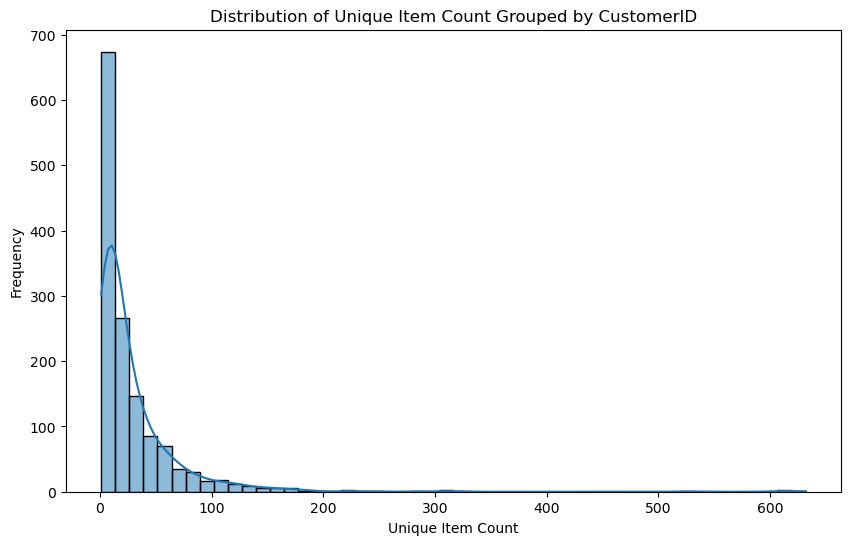

In [24]:
# Distribution of UniqueItemCount
plt.figure(figsize=(10,6))
sns.histplot(df_grouped_CustomerID['UniqueItemCount'], bins=50, kde=True)
plt.title('Distribution of Unique Item Count Grouped by CustomerID')
plt.xlabel('Unique Item Count')
plt.ylabel('Frequency')
plt.show()

In [26]:

# Get all item pairs
item_pairs = df_grouped_CustomerID['ItemNames'].apply(lambda x: list(combinations(x, 2)))

# Flatten the list of item pairs
item_pairs = [item for sublist in item_pairs for item in sublist]

# Get frequency of each pair
pair_counts = Counter(item_pairs)

# Convert to DataFrame
pair_counts_df = pd.DataFrame.from_dict(pair_counts, orient='index').reset_index()
pair_counts_df.columns = ['Item_Pair', 'Frequency']
pair_counts_df.sort_values(by='Frequency', ascending=False, inplace=True)
pair_counts_df.reset_index(inplace=True, drop=True)

# Get all item pairs
item_triples = df_grouped_CustomerID['ItemNames'].apply(lambda x: list(combinations(x, 3)))

# Flatten the list of item pairs
item_triples = [item for sublist in item_triples for item in sublist]

# Get frequency of each pair
triple_counts = Counter(item_triples)

# Convert to DataFrame
triple_counts_df = pd.DataFrame.from_dict(triple_counts, orient='index').reset_index()
triple_counts_df.columns = ['Item_Pair', 'Frequency']
triple_counts_df.sort_values(by='Frequency', ascending=False, inplace=True)
triple_counts_df.reset_index(inplace=True, drop=True)

In [27]:
print("Pair Counts:", pair_counts_df.shape[0])
print("Triple Counts:", triple_counts_df.shape[0])

Pair Counts: 811093
Triple Counts: 59115647


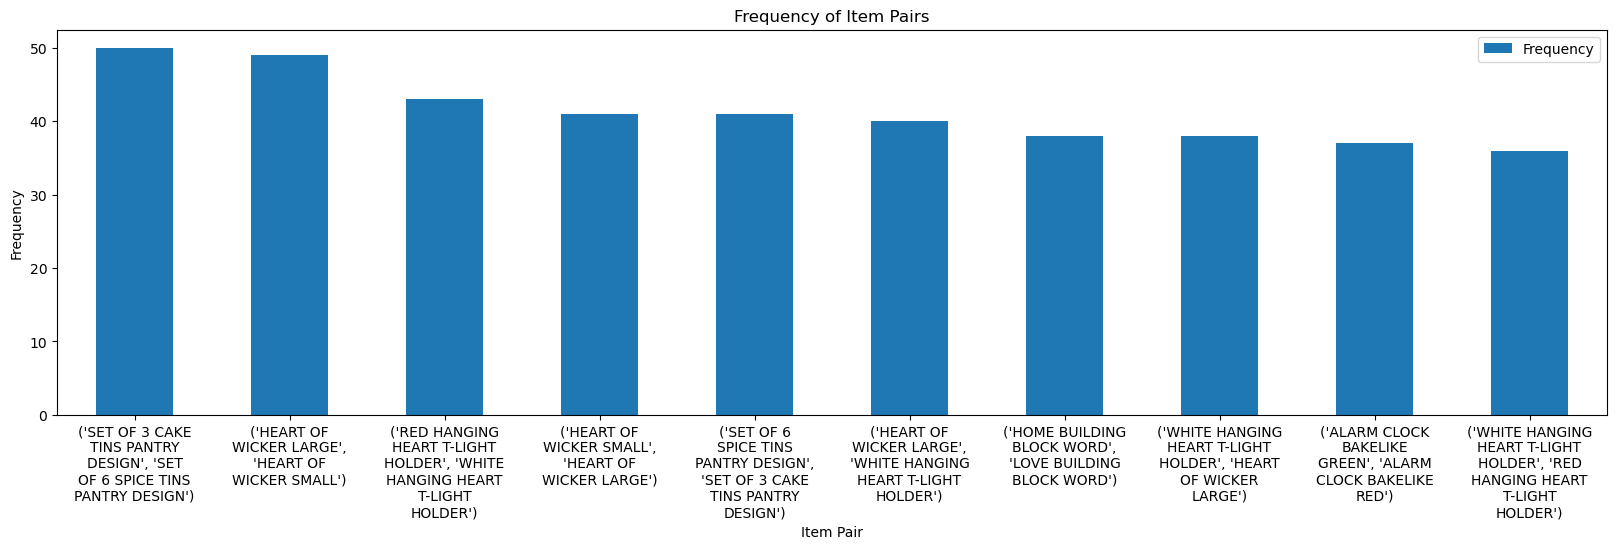

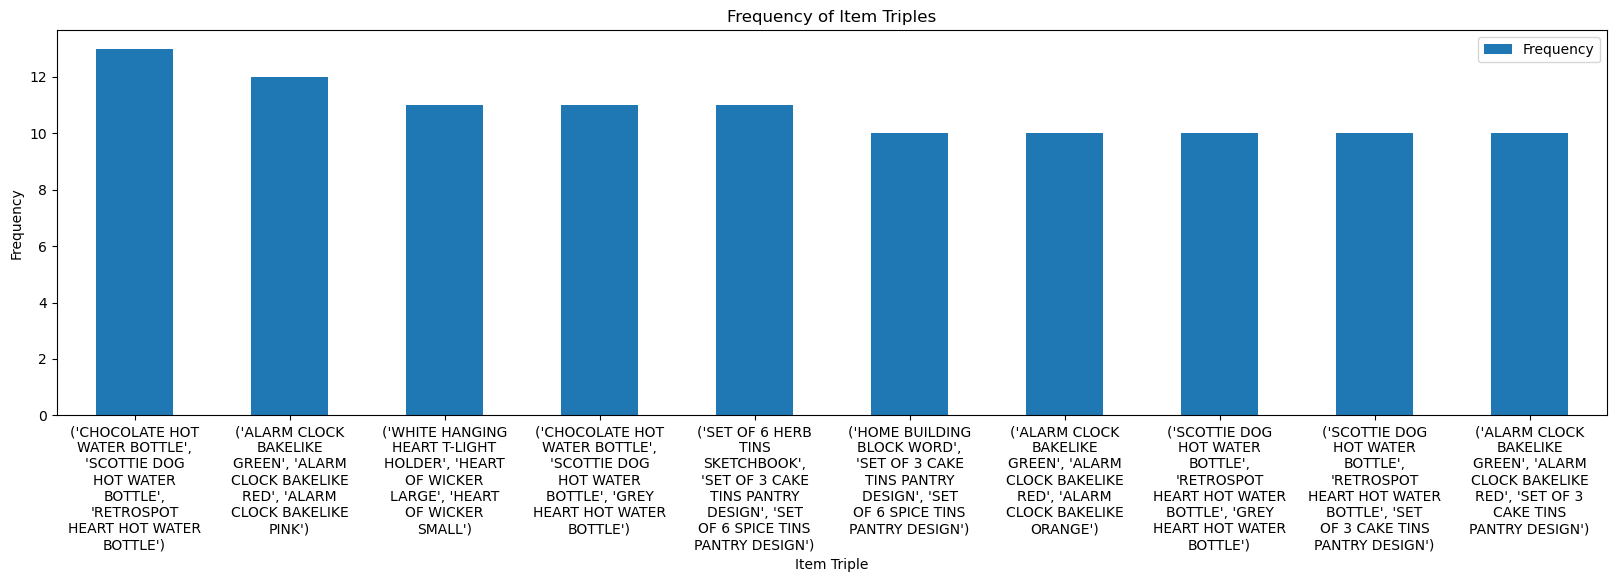

In [28]:
# Plot the top 10 most frequently bought item pairs
pair_counts_df[:10].plot(kind='bar', figsize=(20,5), x='Item_Pair', y='Frequency')
plt.title('Frequency of Item Pairs')
plt.xlabel('Item Pair')

# Wrap the labels
labels = [textwrap.fill(str(label), width=15) for label in pair_counts_df['Item_Pair'][:10]]
plt.xticks(range(len(labels)), labels, rotation=0)

plt.ylabel('Frequency')
plt.show()


# Plot the top 10 most frequently bought item triples
triple_counts_df[:10].plot(kind='bar', figsize=(20,5), x='Item_Pair', y='Frequency')
plt.title('Frequency of Item Triples')
plt.xlabel('Item Triple')

# Wrap the labels
labels = [textwrap.fill(str(label), width=15) for label in triple_counts_df['Item_Pair'][:10]]
plt.xticks(range(len(labels)), labels, rotation=0)

plt.ylabel('Frequency')
plt.show()

In [29]:
# Co-occurrence of items
pivot_df = df_train.groupby(['CustomerID', 'Itemname']).size().unstack().fillna(0)

# Convert pivot_df to binary format
pivot_df_binary = pivot_df.applymap(lambda x: 1 if x > 0 else 0)

# Association rules
frequent_itemsets = apriori(pivot_df_binary, min_support=0.01, use_colnames=True)
display(frequent_itemsets)

c:\Users\axell\anaconda3\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
0,0.010065,(12 DAISY PEGS IN WOOD BOX)
1,0.010065,(12 IVORY ROSE PEG PLACE SETTINGS)
2,0.015097,(12 MESSAGE CARDS WITH ENVELOPES)
3,0.015097,(12 PENCIL SMALL TUBE WOODLAND)
4,0.020848,(12 PENCILS SMALL TUBE RED RETROSPOT)
...,...,...
3662,0.012940,"(ALARM CLOCK BAKELIKE RED, ALARM CLOCK BAKELIK..."
3663,0.010784,"(HEART OF WICKER LARGE, WHITE HANGING HEART T-..."
3664,0.010065,"(I'M ON HOLIDAY METAL SIGN, COOK WITH WINE MET..."
3665,0.010065,"(LUNCH BAG CARS BLUE, LUNCH BAG SUKI DESIGN, ..."


In [8]:
print("Number of Itemsets above 0.0075 threshold", len(frequent_itemsets))

Number of Itemsets above 0.0075 threshold 3667


In [17]:
# Generate association rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.75)
display(rules)
print("Number of Rules", len(rules))
display(rules.describe())

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(60 CAKE CASES DOLLY GIRL DESIGN),(72 SWEETHEART FAIRY CAKE CASES),0.017254,0.042416,0.012940,0.750000,17.682203,0.012209,3.830338,0.960010
1,(PACK OF 60 DINOSAUR CAKE CASES),(72 SWEETHEART FAIRY CAKE CASES),0.022286,0.042416,0.017254,0.774194,18.252597,0.016308,4.240731,0.966759
2,(ALARM CLOCK BAKELIKE CHOCOLATE),(ALARM CLOCK BAKELIKE GREEN),0.025162,0.064702,0.020848,0.828571,12.806032,0.019220,5.455907,0.945707
3,(ALARM CLOCK BAKELIKE CHOCOLATE),(ALARM CLOCK BAKELIKE RED),0.025162,0.069734,0.020129,0.800000,11.472165,0.018375,4.651330,0.936394
4,(ALARM CLOCK BAKELIKE ORANGE),(ALARM CLOCK BAKELIKE GREEN),0.035226,0.064702,0.028037,0.795918,12.301361,0.025758,4.582962,0.952253
...,...,...,...,...,...,...,...,...,...,...
949,"(LUNCH BAG DOLLY GIRL DESIGN, LUNCH BAG SUKI ...",(LUNCH BAG SPACEBOY DESIGN),0.010065,0.066139,0.010065,1.000000,15.119565,0.009399,inf,0.943355
950,"(LUNCH BAG DOLLY GIRL DESIGN, LUNCH BAG SUKI ...",(LUNCH BAG RED RETROSPOT),0.011503,0.084831,0.010065,0.875000,10.314619,0.009089,7.321352,0.913558
951,"(LUNCH BAG DOLLY GIRL DESIGN, LUNCH BAG RED RE...",(LUNCH BAG SUKI DESIGN),0.010784,0.063264,0.010065,0.933333,14.753030,0.009382,14.051042,0.942380
952,"(LUNCH BAG DOLLY GIRL DESIGN, LUNCH BAG SUKI ...","(LUNCH BAG RED RETROSPOT, LUNCH BAG SPACEBOY D...",0.012940,0.038821,0.010065,0.777778,20.034979,0.009562,4.325306,0.962543


Number of Rules 954


,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
count,954.000000,954.000000,954.000000,954.000000,954.000000,954.000000,954.000000,954.000000
mean,0.014857,0.063005,0.012490,0.851046,23.210522,0.011525,inf,0.938406
std,0.005045,0.037228,0.003807,0.076326,23.968320,0.003405,NaN,0.045658
min,0.010065,0.010065,0.010065,0.750000,5.113971,0.008167,3.413372,0.816193
25%,0.012221,0.039540,0.010065,0.782609,9.707876,0.009600,4.332225,0.910697
50%,0.013659,0.051761,0.011503,0.826837,15.268954,0.010353,5.468218,0.948314
75%,0.016535,0.084831,0.012940,0.900000,21.679416,0.012150,9.514738,0.968282
max,0.084831,0.146657,0.065421,1.000000,92.733333,0.053528,inf,1.000000


### 3. Pre-process the data

#### 3.1 Process Training Data

In [11]:
# Create a copy of the df_train dataframe
df = df_train.copy()
df.drop(columns=['BillNo', 'Date', 'cost', 'Price'], inplace=True)
df.dropna(inplace=True)
df['Frequency'] = 1
df = df[['CustomerID', 'Itemname', 'Quantity', 'Frequency']].groupby(['CustomerID', 'Itemname']).sum().reset_index()

# Encode the item names into integers
item_encoder = {item: i for i, item in enumerate(df['Itemname'].unique())}
df['ItemID'] = df['Itemname'].map(item_encoder)

df_encoded_train = df.copy()

sparse_item_customer_train = sparse.csr_matrix((df_encoded_train['Frequency'].astype(float), (df_encoded_train['ItemID'], df_encoded_train['CustomerID'])))
sparse_customer_item_train = sparse_item_customer_train.T.tocsr()

#### 3.2 Process Testing Data

In [12]:
# Create a copy of the df_test dataframe
df = df_test.copy()
df.drop(columns=['BillNo', 'Date', 'cost'], inplace=True)
df.dropna(inplace=True)

df = df[df['Itemname'].isin(df_train['Itemname'].unique())]

# Convert the Quantity and CustomerID columns to integers
df['Quantity'] = df['Quantity'].astype(int)
df['CustomerID'] = df['CustomerID'].astype(int)

# Encode the item names into integers and add the ItemID column
df['ItemID'] = df['Itemname'].map(item_encoder)
df['ItemID'] = df['ItemID'].astype(int)

df['Frequency'] = 1

df_old_customer = df[df['CustomerID'].isin(df_train['CustomerID'].unique())]
df_new_customer = df[~df['CustomerID'].isin(df_train['CustomerID'].unique())]

# Group by CustomerID, Itemname and ItemID and sum the Quantity
df_encoded_test_old_customer = df_old_customer[['CustomerID', 'Itemname', 'Quantity', 'ItemID', 'Frequency']].groupby(['CustomerID', 'Itemname', 'ItemID']).sum().reset_index()
df_encoded_test_new_customer = df_new_customer[['CustomerID', 'Itemname', 'Quantity', 'ItemID', 'Frequency']].groupby(['CustomerID', 'Itemname', 'ItemID']).sum().reset_index()

# Create the sparse matrices
sparse_item_customer_test = sparse.csr_matrix((df_encoded_test_old_customer['Frequency'].astype(float), (df_encoded_test_old_customer['ItemID'], df_encoded_test_old_customer['CustomerID'])))
sparse_customer_item_test = sparse_item_customer_test.T.tocsr()

interaction_matrix_new_customer = pd.pivot_table(df_encoded_test_new_customer, values='Frequency', index='CustomerID', columns='ItemID', fill_value=0)

### 4. Implement, train and test prediction models

In [13]:
train = sparse_customer_item_train
test = sparse_customer_item_test
K = 20

In [71]:
def evaluate(train, test, k, model):
    AUC = AUC_at_k(model, train, test, K=k, show_progress=False)
    print(f"AUC@{k}:",AUC)

    MAP = mean_average_precision_at_k(model, train, test, K=k, show_progress=False)
    print(f"MAP@{k}:",MAP)

    NDCG = ndcg_at_k(model, train, test, K=k, show_progress=False)
    print(f"NDCG@{k}:",NDCG)
    
    return AUC, MAP, NDCG

In [86]:
def calculate_map(y_true_list, y_score_list):
    ap_scores = [average_precision_score(y_true, y_score) for y_true, y_score in zip(y_true_list, y_score_list)]
    return sum(ap_scores) / len(ap_scores)

def evaluate_top_seller(interaction_matrix, top_selling, k):
    # Initialize lists to store the true labels and the predicted scores
    y_true = []
    y_score = []
    for customer_id in interaction_matrix.index:
        # Get the items the user actually interacted with in the test set
        actual = interaction_matrix.loc[customer_id]
        actual = actual[actual > 0].index.values
        
        # Create a binary label for each item: 1 if the user interacted with it, 0 otherwise
        labels = [1 if item in actual else 0 for item in top_selling]
        y_true.append(labels)
        
        # The predicted score for each item is its rank in reverse order
        scores = list(np.arange(K, 0, -1))
        y_score.append(scores)

    # Calculate the metrics
    auc = roc_auc_score(y_true, y_score)
    map_score = calculate_map(y_true, y_score)
    ndcg = ndcg_score(y_true, y_score)

    print(f'AUC@{k}:', auc)
    print(f'MAP@{k}:', map_score)
    print(f'NDCG@{k}:', ndcg)
    
    return auc, map_score, ndcg 

#### 4.1 Alternating Least Squares Model

In [27]:
model_ALS = implicit.als.AlternatingLeastSquares(factors=64, regularization=0.1, iterations=50, random_state=42)

model_ALS.fit(train, show_progress=False)

In [72]:
AUC_ALS, MAP_ALS, NDCG_ALS = evaluate(train, test, K, model_ALS)

AUC@20: 0.5403089421924973
MAP@20: 0.04086476542512466
NDCG@20: 0.09421474045092162


#### 4.2 Bayesian Personalized Ranking Model

In [29]:
model_BPR = implicit.bpr.BayesianPersonalizedRanking(factors=64, regularization=0.1, iterations=50, random_state=42)

model_BPR.fit(train, show_progress=False)

In [73]:
AUC_BPR, MAP_BPR, NDCG_BPR = evaluate(train, test, K, model_BPR)

AUC@20: 0.5126303129860296
MAP@20: 0.009833698847636093
NDCG@20: 0.03725772536593007


#### 4.3 Logistic Matrix Factorization Model

In [31]:
model_LMF = implicit.lmf.LogisticMatrixFactorization(factors=64, regularization=0.1, iterations=50, random_state=42)
model_LMF.fit(train, show_progress=False)

In [32]:
AUC_LMF, MAP_LMF, NDCG_LMF = evaluate(train, test, K, model_LMF)

AUC@20: 0.5267587293042234
MAP@20: 0.018449577840910208
NDCG@20: 0.05314899273301233


#### 4.4 Top Seller Model (New Customer Only)

In [65]:
# Group by Itemname and ItemID and sum the Quantity
df_top_seller = df_encoded_train[['Itemname', 'Quantity', 'ItemID', 'Frequency']].groupby(['Itemname', 'ItemID']).sum().sort_values('Frequency', ascending=False)

# Get the top K items
def recommend_top_selling(k):
    return df_top_seller.index[:k].get_level_values('ItemID').to_list()

In [90]:
# Get the top k selling items
top_selling = recommend_top_selling(K)

AUC_top_seller, MAP_top_seller, NDCG_top_seller = evaluate_top_seller(interaction_matrix_new_customer, top_selling, K)

AUC@20: 0.5
MAP@20: 0.17537889210889118
NDCG@20: 0.2852084906647702


### 5. Compare the models

In [88]:
# Create a dictionary with the evaluation scores
evaluation_scores = {
    'Model': ['ALS', 'BPR', 'LMF', 'Top Seller (New Customer only)'],
    f'AUC@{K}': [AUC_ALS, AUC_BPR, AUC_LMF, AUC_top_seller],
    f'MAP@{K}': [MAP_ALS, MAP_BPR, MAP_LMF, MAP_top_seller],
    f'NDCG@{K}': [NDCG_ALS, NDCG_BPR, NDCG_LMF, NDCG_top_seller],
}

# Create a DataFrame from the dictionary
evaluation_table = pd.DataFrame(evaluation_scores)

# Display the table
display(evaluation_table)

,Model,AUC@20,MAP@20,NDCG@20
0,ALS,0.540309,0.040865,0.094215
1,BPR,0.512630,0.009834,0.037258
2,LMF,0.526759,0.018450,0.053149
3,Top Seller (New Customer only),0.500000,0.175379,0.285208


ALS model is the best, combined with Top Seller to recommend items to new Customer with no past transaction history.

In [60]:
item_decoder = {i: item for item, i in item_encoder.items()}

In [67]:
import pandas as pd
# Create 
df_cust = df_encoded_test_old_customer[['CustomerID', 'ItemID']].groupby('CustomerID').aggregate(lambda x: list(x)).reset_index()
df_cust['Recommend'] = df_cust['CustomerID'].apply(lambda x: model_ALS.recommend(x, train, N=K, filter_already_liked_items=False)[0])
df_cust['Score'] = df_cust['CustomerID'].apply(lambda x: model_ALS.recommend(x, train, N=K, filter_already_liked_items=False)[1])
df_cust['Intersect'] = df_cust.apply(lambda row: set(row['ItemID']).intersection(set(row['Recommend'])), axis=1)
df_cust['Intersect %'] = df_cust.apply(lambda x: len(x['Intersect'])/len(x['ItemID']) * 100, axis=1)
df_cust = df_cust[(df_cust['Intersect %'] > 80) & (df_cust['ItemID'].apply(len) > 4)]
df_cust['Score'] = df_cust.apply(lambda row: [row['Score'][row['Recommend'].tolist().index(item)] for item in row['Intersect']], axis=1)
df_cust['Item Name'] = df_cust['ItemID'].apply(lambda x: [item_decoder[i] for i in x])
df_cust['Recommend'] = df_cust['Recommend'].apply(lambda x: [item_decoder[i] for i in x])
df_cust['Intersect'] = df_cust['Intersect'].apply(lambda x: [item_decoder[i] for i in x])
# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

# Your code here
display(df_cust[['CustomerID', 'Item Name', 'Intersect', 'Score', 'Intersect %']])

# Reset display options to default
pd.reset_option('display.max_columns')
pd.reset_option('display.max_rows')
pd.reset_option('display.max_colwidth')


,CustomerID,Item Name,Intersect,Score,Intersect %
21,12712,"[3 HOOK PHOTO SHELF ANTIQUE WHITE, BLUE COAT RACK PARIS FASHION, IVORY GIANT GARDEN THERMOMETER, WOODEN FRAME ANTIQUE WHITE, WOODEN PICTURE FRAME WHITE FINISH]","[WOODEN FRAME ANTIQUE WHITE, IVORY GIANT GARDEN THERMOMETER, WOODEN PICTURE FRAME WHITE FINISH, BLUE COAT RACK PARIS FASHION, 3 HOOK PHOTO SHELF ANTIQUE WHITE]","[0.54160106, 0.48499346, 0.4241623, 0.3602286, 0.4474218]",100.000000
59,13742,"[CANDLEHOLDER PINK HANGING HEART, HOME BUILDING BLOCK WORD, IVORY GIANT GARDEN THERMOMETER, LOVE BUILDING BLOCK WORD, MA CAMPAGNE CUTLERY BOX, SET OF 6 SPICE TINS PANTRY DESIGN, WHITE HANGING HEART T-LIGHT HOLDER, WOODEN FRAME ANTIQUE WHITE, WOODEN PICTURE FRAME WHITE FINISH]","[WOODEN FRAME ANTIQUE WHITE, SET OF 6 SPICE TINS PANTRY DESIGN, IVORY GIANT GARDEN THERMOMETER, WOODEN PICTURE FRAME WHITE FINISH, LOVE BUILDING BLOCK WORD, CANDLEHOLDER PINK HANGING HEART, WHITE HANGING HEART T-LIGHT HOLDER, HOME BUILDING BLOCK WORD]","[1.1508428, 1.0952762, 1.1196388, 0.94205403, 0.9090387, 0.9727556, 1.2830827, 1.091254]",88.888889
60,13767,"[ALARM CLOCK BAKELIKE GREEN, ALARM CLOCK BAKELIKE RED, DOORMAT WELCOME TO OUR HOME, GREEN REGENCY TEACUP AND SAUCER, PINK REGENCY TEACUP AND SAUCER, REGENCY CAKESTAND 3 TIER, ROSES REGENCY TEACUP AND SAUCER]","[ALARM CLOCK BAKELIKE GREEN, PINK REGENCY TEACUP AND SAUCER, ALARM CLOCK BAKELIKE RED, REGENCY CAKESTAND 3 TIER, GREEN REGENCY TEACUP AND SAUCER, ROSES REGENCY TEACUP AND SAUCER]","[1.0302672, 0.42271474, 0.9985105, 1.0901626, 0.8569158, 0.9580794]",85.714286
85,14466,"[RECIPE BOX BLUE SKETCHBOOK DESIGN, RECIPE BOX PANTRY YELLOW DESIGN, RECIPE BOX RETROSPOT, RED RETROSPOT APRON, RED RETROSPOT CAKE STAND, REGENCY CAKESTAND 3 TIER]","[RECIPE BOX PANTRY YELLOW DESIGN, RECIPE BOX BLUE SKETCHBOOK DESIGN, RED RETROSPOT APRON, REGENCY CAKESTAND 3 TIER, RECIPE BOX RETROSPOT, RED RETROSPOT CAKE STAND]","[0.3083158, 0.14942434, 0.20679508, 0.97753435, 0.32583565, 0.58021206]",100.000000
182,16722,"[JUMBO STORAGE BAG SKULLS, LUNCH BAG BLACK SKULL., LUNCH BAG CARS BLUE, LUNCH BAG DOLLY GIRL DESIGN, LUNCH BAG PINK POLKADOT, LUNCH BAG RED RETROSPOT, LUNCH BAG SPACEBOY DESIGN, LUNCH BAG SUKI DESIGN, LUNCH BAG WOODLAND]","[LUNCH BAG SPACEBOY DESIGN, LUNCH BAG SUKI DESIGN, LUNCH BAG DOLLY GIRL DESIGN, LUNCH BAG CARS BLUE, LUNCH BAG PINK POLKADOT, LUNCH BAG WOODLAND, LUNCH BAG BLACK SKULL., LUNCH BAG RED RETROSPOT]","[0.7280563, 0.80547434, 0.542163, 0.7454314, 0.5851331, 0.61073554, 0.771979, 0.8967705]",88.888889


According to the AUC metric, all models are around 0.5, meaning that their recommendations are close to being random (Allwright, 2022), especially the top sales model that has 0.5 AUC score which does not provide any useful recommendation as it was not personalized to any users.